In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import os
import sys
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

from scipy.ndimage import rotate
from pretrained_models.resnet20 import ResNetCIFAR

from utils import *
from importlib import reload
reload(sys.modules['utils'])

2023-12-11 07:22:16.487490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 07:22:16.487557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 07:22:16.488827: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 07:22:16.498769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 07:22:17.759078: W tensorflow/compiler/tf2

<module 'utils' from '/workspaces/Adversarial-Patches-Experimentation/10_code/utils.py'>

## Outstanding Questions

1. What transformations should we apply to CIFAR-10 clean data?

## Obtain CIFAR-10 Clean Data

In [2]:
# PARAMS
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_size = 0.1
target = 1 #automobile

In [3]:
# TODO: should we apply the below transformations?
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

transform_image = transforms.ToPILImage()

In [4]:
print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(root='../00_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# load the Pre-Trained ResNet-20 model
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)
net.load_state_dict(torch.load("./pretrained_models/pretrained_model.pt"))

<All keys matched successfully>

## Question: what does mean and std mean in this context?
1. Why are we only taking one target probability in the attack function in utils.py?

In [6]:
min_in, max_in = 32, 32
min_in, max_in = np.array([min_in, min_in, min_in]), np.array([max_in, max_in, max_in])
#mean, std = 2, np.array(4) 
#min_out, max_out = np.min((min_in-mean)/std), np.max((max_in-mean)/std)
min_out, max_out = 0, 1

In [7]:
patch, patch_shape = init_patch_circle(32, patch_size, batch_size)
target = 8 #automobile
for epoch in range(1, 10):
    print("Epoch: ", epoch)
    print("Shape of patch: ", patch.shape)
    patch = train(
        epoch,
        patch,
        patch_shape,
        net,
        trainloader,
        target = 8 ,
        device=device,
        patch_type="circle",
        image_size=32
    )

    test(
        epoch,
        patch,
        patch_shape,
        net,
        testloader,
        target = 8,
        image_size = 32,
        min_out = 0,
        max_out = 1,
        device="cuda",
        patch_type="circle"
    )

Epoch:  1


/workspaces/Adversarial-Patches-Experimentation/10_code/utils.py:310: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_out = F.softmax(netClassifier(x))
/workspaces/Adversarial-Patches-Experimentation/10_code/utils.py:327: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  adv_out = F.log_softmax(netClassifier(adv_x))
/workspaces/Adversarial-Patches-Experimentation/10_code/utils.py:344: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(netClassifier(adv_x))


Epoch 1: Train Patch Success: 0.691
Epoch 1: Test Patch Success: 0.109
Epoch:  2


In [2]:
def patch_application_operator(img_index, patch_path = '../00_data/patches/toaster_patch.png', h = 'center', v = 'center', ratio = 3, rotation = 0):
    """A Patch Application Operator function to apply a patch along with its transformations
      to a CIFAR-10 image given an index in the training / test set.
    
    Args:
        img_index (int): the index of the image in the training / test set
        patch_path (str): the path to the patch image
        h (str): the horizontal position of the patch (default: 'center') - see mode_to_value keys for possible values
        v (str): the vertical position of the patch (default: 'center') - see mode_to_value keys for possible values
        ratio (int): the ratio of the patch size to the image size (default: 3). Essentially controls the scale of the image.
        rotation (int): the angle of rotation of the patch (default: 0)

    Returns:
        img (PIL): the image with the patch applied
    
    """

    #TODO: add more transformation options for the patch

    image = transform_image(trainset[img_index][0])
    
    patch_image = Image.open(patch_path)
    patch_image = patch_image.resize((image.width // ratio, image.height // ratio), Image.Resampling.LANCZOS)
    patch_image = patch_image.rotate(rotation)

    # map from mode value to a function that returns the correct value position
    mode_to_value = {
        'left': lambda width, path: 0,
        'center_h': lambda width, path: width // 2 - path.width // 2,
        'center_v': lambda height, path: height // 2 - path.height // 2, 
        'right': lambda width, path: width - path.width,
        'up': lambda height, path: 0,
        'down': lambda height, path: height - path.height,
    }

    plt.figure(figsize=(2.5, 2.5))
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')  
    plt.show()
    

    x = mode_to_value[h if h != 'center' else 'center_h'](image.width, patch_image)
    y = mode_to_value[v if v != 'center' else 'center_v'](image.height, patch_image)

    print(f"Patch will be placed {h}-{v}")

    image.paste(patch_image, (x, y), mask = patch_image)
    
    plt.figure(figsize=(2.5, 2.5))
    plt.title("Patched")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # convert image to tensor
    image = transform_test(image)
    
    return image


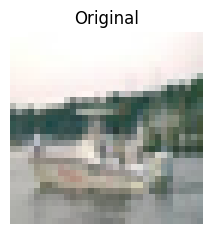

Patch will be placed left-up


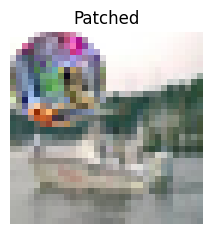

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9843, 0.9647],
         [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9765, 0.9569],
         [0.9882, 0.9922, 0.8353,  ..., 0.9804, 0.9686, 0.9529],
         ...,
         [0.6863, 0.6784, 0.6784,  ..., 0.5882, 0.5765, 0.5529],
         [0.6863, 0.6784, 0.6745,  ..., 0.5647, 0.5373, 0.5294],
         [0.6745, 0.6784, 0.6706,  ..., 0.5765, 0.5412, 0.5020]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9569, 0.9451, 0.9373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9490, 0.9373, 0.9294],
         [0.9922, 1.0000, 0.4392,  ..., 0.9412, 0.9294, 0.9255],
         ...,
         [0.6902, 0.6824, 0.6824,  ..., 0.6039, 0.5961, 0.5922],
         [0.6902, 0.6824, 0.6784,  ..., 0.5804, 0.5569, 0.5686],
         [0.6784, 0.6824, 0.6745,  ..., 0.5922, 0.5608, 0.5373]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9529, 0.9412, 0.9333],
         [0.9843, 0.9843, 0.9843,  ..., 0.9451, 0.9333, 0.9216],
         [0.9686, 0.9765, 0.6196,  ..., 0.9373, 0.9255, 0.

In [28]:
patch_application_operator(240, h = 'left', v = 'up', ratio = 2, rotation = 180)

## Train Models on Clean Data

### Loading Helper Functions

In [29]:
def train(net, epochs, batch_size, lr, reg, 
          transform_train=transform_train, 
          transform_test=transform_test, 
          log_every_n=50, 
          device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Training a network
    :param net: Network for training
    :param epochs: Number of epochs in total.
    :param batch_size: Batch size for training.
    """
    print('==> Preparing data..')

    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    trainset = torchvision.datasets.CIFAR10(root='../00_data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

    testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.875, weight_decay=reg, nesterov=False)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs*0.5), int(epochs*0.75)], gamma=0.1)

    global_steps = 0
    start = time.time()

    for epoch in range(start_epoch, epochs):
        """
        Start the training code.
        """
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            global_steps += 1

            if global_steps % log_every_n == 0:
                end = time.time()
                num_examples_per_second = log_every_n * batch_size / (end - start)
                print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                      % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
                start = time.time()

        scheduler.step()

        """
        Start the testing code.
        """
        net.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        num_val_steps = len(testloader)
        val_acc = correct / total
        print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "pretrained_model.pt")

def test(net, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

    ])

    testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))


In [16]:
# ResNet, DenseNet and VGG

# Load the pretrained model from pytorch - okay this is probably wrong. look into this
resnet = torchvision.models.resnet18(pretrained=True)
vgg = torchvision.models.vgg16(pretrained=True)
densenet = torchvision.models.densenet161(pretrained=True)    

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated sin

In [22]:
train(resnet, 20, batch_size, lr=0.002, reg=1e-4)

==> Preparing data..
Files already downloaded and verified


/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified

Epoch: 0


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/codespace/.python/current/lib/python3.10/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/codespace/.local/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 428, in reduce_storage
    fd, size = storage._share_fd_cpu_()
  File "/home/codespace/.local/lib/python3.10/site-packages/torch/storage.py", line 297, in wrapper
    return fn(self, *args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packa

RuntimeError: DataLoader worker (pid 12050) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

## TEST CELLS - IGNORE STUFF BELOW


In [62]:
h = 'right'
v = 'center'
ratio = 3

PATCH_PATH = '../00_data/patches/toaster_patch.png'
src_img = '../00_data/test_images/banana.jpeg'
save_path = '../00_data/test_images/banana-patched.jpeg'

mode = {
    'h': h,
    'v': v
}

print(f"Path will be placed {mode['h']}-{mode['v']}")

# map from mode value to a function that returns the correct value position
mode_to_value = {
    'left': lambda width, path: 0,
    'center_h': lambda width, path: width // 2 - path.width // 2,
    'center_v': lambda height, path: height // 2 - path.height // 2,
    'right': lambda width, path: width - path.width,
    'up': lambda height, path: 0,
    'down': lambda height, path: height - path.height,
}

def get_position(mode, image, path):
    x = mode_to_value[mode['h'] if mode['h'] != 'center' else 'center_h'](image.width, path)
    y = mode_to_value[mode['v'] if mode['v'] != 'center' else 'center_v'](image.height, path)
    return x, y

patch_image = Image.open(PATCH_PATH)
src_image = Image.open(src_img)

patch_image = patch_image.resize((src_image.width // ratio, src_image.height // ratio), Image.Resampling.LANCZOS)
position = get_position(mode, src_image, patch_image)

src_image.paste(patch_image, position, mask = patch_image)
src_image.save(save_path)

print(f"Image saved at: {save_path}")

Path will be placed right-center
Image saved at: ../00_data/test_images/banana-patched.jpeg
